In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from EDAspy.optimization import UMDAc
from torch.optim import Adam
import torch.nn.functional as F
from tqdm import tqdm

# Importaciones de módulos personalizados
from limpieza_datos import read_item_index_to_entity_id_file, convert_rating, convert_kg, dataset_split, TrainSet
from custom_mkr import MultiKR
from train_and_evaluate import train_and_evaluate_rec

# 1. Funciones

## 1.1 Lectura de datos

In [ ]:
# Leer los datos de kg_final.txt y convertirlos en una lista de tripletas
def load_triplets(filename):
    with open(filename, 'r') as file:
        triplets = [tuple(map(int, line.strip().split('\t'))) for line in file]
    return triplets

# Función para leer los mapeos de entidades y relaciones
def load_mappings(entity_mapping_file, relation_mapping_file):
    with open(entity_mapping_file, 'r') as file:
        entity_id2index = {line.split()[0]: int(line.split()[1]) for line in file}
    
    with open(relation_mapping_file, 'r') as file:
        relation_to_index = {line.split()[0]: int(line.split()[1]) for line in file}
    
    return entity_id2index, relation_to_index

## 1.2 EDA

In [ ]:
embed_dim = 64  # Dimensionalidad de los embeddings

def run_eda(entity_num, relation_num, embed_dim, model, triples, population_size=10, max_iter=150, dead_iter=10, lower_bound=0, upper_bound=1, lambda_reg=0.1, alpha=0.5):
    # Define la función de coste para UMDAc
    cost_function_wrapper = lambda x: metric_cost_function(
        x[:entity_num * embed_dim].reshape(entity_num, embed_dim),
        x[entity_num * embed_dim:(entity_num + relation_num) * embed_dim].reshape(relation_num, embed_dim),
        model,
        triples,
        lambda_reg
    )

    # Inicializar UMDAc
    umda = UMDAc(
        size_gen=population_size,
        max_iter=max_iter,
        dead_iter=dead_iter,
        n_variables=(entity_num + relation_num) * embed_dim,  # Total de dimensiones para todas las entidades y relaciones
        lower_bound=lower_bound,
        upper_bound=upper_bound,
        alpha=alpha # Este es un valor de ejemplo para el parámetro alpha, puede ser ajustado
    )

    # Ejecutar el algoritmo EDA
    umda_result = umda.minimize(cost_function_wrapper)

    # Devuelve el modelo y el resultado de UMDA
    return model, umda_result


def metric_cost_function(entity_pop, relation_pop, model, triples, lambda_reg):
    # Asignar embeddings al modelo, verificar dimensiones adecuadas
    if entity_pop.shape == model.entity_embed.weight.shape and relation_pop.shape == model.relation_embed.weight.shape:
        model.entity_embed.weight.data = torch.tensor(entity_pop, dtype=torch.float32, device=model.entity_embed.weight.device)
        model.relation_embed.weight.data = torch.tensor(relation_pop, dtype=torch.float32, device=model.relation_embed.weight.device)
    else:
        print("Mismatch in embedding shapes!")
        return float('inf')  # Retorna un valor de 'infinito' si hay un error en las formas

    # Calcula el coste usando la función de coste definida previamente
    cost = cost_function_hiperbolic(entity_pop, relation_pop, triples, lambda_reg)
    return cost

## 1.3 Función de coste

In [ ]:
import numpy as np

# Función para calcular la distancia euclidiana entre dos embeddings
def euclidean_distance(embedding1, embedding2):
    return np.sqrt(np.sum((embedding1 - embedding2) ** 2))

# Función de coste que incluye cercanía semántica, consistencia y diversidad
def cost_function(entity_embeddings, relation_embeddings, triples, lambda_reg):
    # Cercanía semántica
    semantic_closeness_cost = sum(euclidean_distance(entity_embeddings[head] + relation_embeddings[relation], entity_embeddings[tail]) for head, relation, tail in tqdm(triples, desc='Calculando cercanía semántica'))
    
    # Consistencia
    consistency_cost = 0  # Esta parte se mantiene igual
    
    # Diversidad con barra de progreso
    diversity_cost = 0
    for i in tqdm(range(len(entity_embeddings)), desc='Calculando diversidad'):
        for j in range(i+1, len(entity_embeddings)):
            diversity_cost += lambda_reg * euclidean_distance(entity_embeddings[i], entity_embeddings[j])

    # Combinación de costes
    total_cost = semantic_closeness_cost + consistency_cost + diversity_cost
    print(total_cost)
    return total_cost



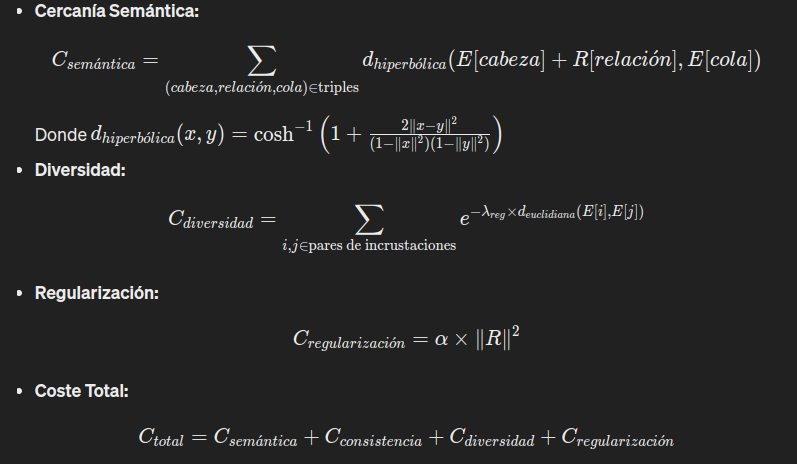

In [ ]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
from tqdm import tqdm

# Función para calcular la distancia hiperbólica entre dos embeddings
def hyperbolic_distance(embedding1, embedding2):
    delta = 1 + 2 * np.sum((embedding1 - embedding2) ** 2) / ((1 - np.sum(embedding1 ** 2)) * (1 - np.sum(embedding2 ** 2)))
    return np.arccosh(delta)

# Función de coste que incluye cercanía semántica, consistencia, diversidad y regularización probabilística
def cost_function_hiperbolic(entity_embeddings, relation_embeddings, triples, lambda_reg, alpha=0.1):
    # Cercanía semántica usando distancia hiperbólica
    semantic_closeness_cost = sum(hyperbolic_distance(entity_embeddings[head] + relation_embeddings[relation], entity_embeddings[tail]) for head, relation, tail in tqdm(triples, desc='Calculando cercanía semántica'))

    # Consistencia: este componente puede ser desarrollado según necesidades específicas
    consistency_cost = 0

    # Diversidad mejorada y regularización probabilística
    # Usando la entropía de las distancias para penalizar las incrustaciones excesivamente similares
    pairwise_distances = squareform(pdist(entity_embeddings, 'euclidean'))
    diversity_cost = np.sum(np.exp(-pairwise_distances * lambda_reg))  # Diversidad con penalización suave

    # Regularización basada en la norma de Frobenius de las incrustaciones de relaciones
    regularization_cost = alpha * np.sum(relation_embeddings ** 2)

    # Combinación de costes
    total_cost = semantic_closeness_cost + consistency_cost + diversity_cost + regularization_cost
    print("Coste total:", total_cost)
    return total_cost

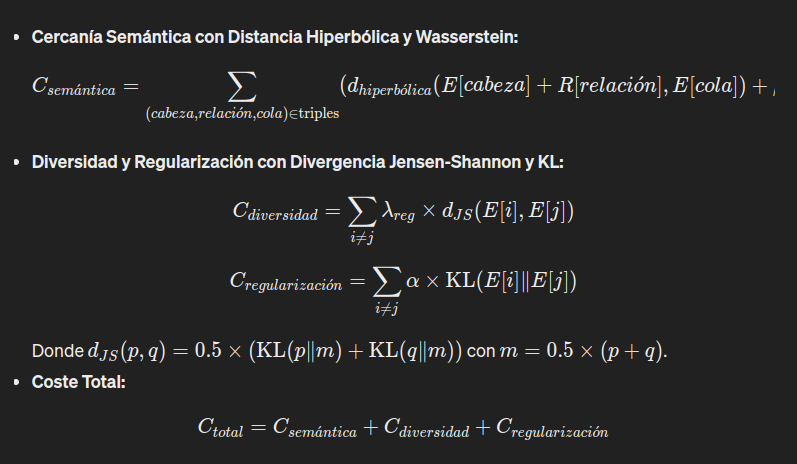

In [ ]:
import numpy as np
from scipy.spatial import distance
from scipy.stats import wasserstein_distance
from scipy.special import kl_div

def js_divergence(p, q):
    m = 0.5 * (p + q)
    return 0.5 * (kl_div(p, m).sum() + kl_div(q, m).sum())

def cost_function_v2(entity_embeddings, relation_embeddings, triples, lambda_reg, alpha=0.1, beta=0.1):
    # Cercanía semántica ajustada con proximidad de primer orden
    semantic_closeness_cost = 0
    for head, relation, tail in triples:
        head_embedding = entity_embeddings[head]
        tail_embedding = entity_embeddings[tail]
        relation_embedding = relation_embeddings[relation]
        # Calculando la distancia hiperbólica para proximidad de primer orden
        distance_cost = hyperbolic_distance(head_embedding + relation_embedding, tail_embedding)
        semantic_closeness_cost += distance_cost

        # Añadiendo proximidad de segundo orden utilizando distancia de Wasserstein
        if np.random.rand() > 0.5:  # Ejemplo de cómo seleccionar aleatoriamente las comparaciones de segundo orden
            semantic_closeness_cost += beta * wasserstein_distance(head_embedding, tail_embedding)

    # Diversidad y regularización basada en métricas de similitud avanzadas
    diversity_cost = 0
    regularization_cost = 0
    for i in range(len(entity_embeddings)):
        for j in range(i + 1, len(entity_embeddings)):
            p = entity_embeddings[i]
            q = entity_embeddings[j]
            # Diversidad mejorada usando Jensen-Shannon
            diversity_cost += lambda_reg * js_divergence(p, q)
            # Regularización usando divergencia KL asimétrica
            regularization_cost += alpha * np.sum(kl_div(p, q))

    # Combinación de costes
    total_cost = semantic_closeness_cost + diversity_cost + regularization_cost
    return total_cost


# 2. Carga de datos

In [ ]:
# Configuración de datos y modelo
_, entity_id2index = read_item_index_to_entity_id_file()
convert_rating(_)
entity_id2index, relation_id2index = convert_kg()
ratings = np.loadtxt('./MKR-data/ratings_final.txt', dtype=np.int32)
train_data, eval_data, test_data = dataset_split(ratings)
train_loader = DataLoader(TrainSet(train_data), batch_size=64, shuffle=True)
val_loader = DataLoader(TrainSet(eval_data), batch_size=64, shuffle=True)
test_loader = DataLoader(TrainSet(test_data), batch_size=64, shuffle=False) 

In [ ]:
# Suponiendo que tenemos los siguientes archivos con los mapeos
entity_id2index, relation_to_index = convert_kg()

# Ahora cargamos las tripletas
triplets = load_triplets('MKR-data/kg_final.txt')

# Suponemos que ya tenemos inicializadas las matrices de embeddings
entity_embeddings = np.random.rand(len(entity_id2index), embed_dim)  # embeddings para entidades
relation_embeddings = np.random.rand(len(relation_to_index), embed_dim)  # embeddings para relaciones

In [ ]:
user_num = len(np.unique(ratings[:, 0]))
item_num = len(np.unique(ratings[:, 1]))
entity_num = len(entity_id2index)
relation_num = len(relation_id2index)

print([user_num, item_num, entity_num, relation_num])

# Extraer el máximo índice usado para usuarios e ítems
max_user_idx = ratings[:, 0].max()
max_item_idx = ratings[:, 1].max()

# Configuración del modelo utilizando estos máximos
model = MultiKR(
    user_num=max_user_idx + 1,  # todos los índices de usuario desde 0 hasta max_user_idx
    item_num=max_item_idx + 1,  # todos los índices de ítem desde 0 hasta max_item_idx
    entity_num=len(entity_id2index),  
    relation_num=len(relation_id2index),  
    n_layer=1,
    embed_dim=64,
    hidden_layers=[64], 
    dropouts=[0.3],
    output_rec=1
)

# 3. Cálculo de embeddings con generaciones de EDA

In [ ]:
model_returned, umda_result = run_eda(
    entity_num=entity_num,
    relation_num=relation_num,
    embed_dim=embed_dim,
    model=model,
    triples=triplets,
    population_size=35,  
    max_iter=150,  
    dead_iter=10,  
    lower_bound=0,  
    upper_bound=1,  
    lambda_reg=0.1,
    alpha=0.5
)

In [ ]:
print(umda_result)

In [ ]:
array= [420344099.91829264, 329541050.734815, 315268730.14970535, 304711309.1830219, 295670559.92087436, 287821970.187551, 280622639.02790827, 274101487.94926, 267978453.84988618, 262444367.63928935, 257003779.6804307, 251961633.592869, 247115777.5220174, 242436617.58779395, 238135829.51301208, 233875103.75639978, 229834885.8693464, 225999161.47721553, 222167743.16686276, 218508361.35907823, 215067718.28760514, 211671385.1284756, 208468870.0308331, 205241870.3961391, 202146918.37768856, 199099653.6762092, 196196044.75480515, 193457593.4128865, 190650636.91590384, 187957817.20663315, 185376705.50782174, 182835515.61365446, 180440193.4384266, 177988118.5398042, 175725505.06829482, 173428892.54826003, 171212840.58286, 168947070.33477142, 166850642.92263222, 164729951.26655665, 162746121.7191275, 160647483.0113346, 158738924.31005198, 156729296.66791838, 154956375.5328319, 153184436.25699592, 151308528.44088563, 149561734.72101235, 147818645.95276678, 146070998.70735276, 144444992.20431155, 142866092.230123, 141236810.90738404, 139697188.33118242, 138131354.85189658, 136583817.65233022, 135135845.998937, 133617680.76728086, 132234497.94611879, 130799610.204261, 129489607.84491579, 128029683.99933338, 126776257.96940497, 125384984.96597148, 124066773.57947414, 122787797.6970886, 121559630.52940555, 120364145.8126658, 119158644.57780866, 117859463.8043184, 116748715.82531963, 115650060.98156905, 114388652.84785931, 113391159.01428425, 112296303.25717148, 111201069.67834735, 110153885.70575981, 109093952.72818077, 108012966.86900523, 107015042.00082698, 106026759.9119906, 104987725.3478454, 104018095.28785363, 103054413.3498007, 102107996.8250481, 101201529.95509273, 100304463.83917072, 99348916.15815507, 98496103.82766673, 97582184.67000721, 96763422.14991951, 95944492.55950592, 95062718.09411901, 94241001.18217377, 93411485.6613365, 92612788.92752284, 91799842.6795935, 91007272.22802776, 90221830.35940157, 89467678.21610223, 88672829.0903315, 87907918.30951498, 87161929.09437631, 86354327.62265322, 85706825.25579181, 85000520.3460079, 84263619.63670701, 83595309.10802303, 82852881.42274255, 82189063.77347279, 81527436.98946306, 80841143.09220399, 80218826.76217914, 79497600.31208348, 78902547.98704809, 78262868.47855182, 77628550.22117299, 76995282.54735091, 76399880.03992575, 75832670.25084405, 75200694.08890858, 74648146.20761882, 74082727.12051536, 73526187.16683826, 72925502.08758757, 72362175.3776707, 71793602.58471902, 71265945.39292534, 70729295.31794836, 70176249.39108971, 69652917.58561611, 69130205.42964289, 68547355.15884234, 68097030.85668701, 67574606.33278026, 67045580.30096022, 66534495.3454892, 66071918.653396524, 65569083.319631256, 65093821.809341066, 64591799.63794504, 64137435.350109756, 63643478.78788833, 63212596.818173975, 62727366.571486026, 62245369.921933725, 61821750.15025655, 61357447.50778597, 60933969.65899389, 60513727.11962087]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
generations = np.arange(len(array))  # Generaciones (eje X)
plt.figure(figsize=(10, 5))
plt.plot(generations, array, marker='o', linestyle='-', color='b')
# plt.yscale('log')  # Escala logarítmica en el eje Y
plt.title('Best Cost per Generation')
plt.xlabel('Generation')
plt.ylabel('Best Cost')
plt.grid(True, which="both", ls="--")
plt.show()

In [ ]:
model_returned.entity_embed.weight.data

In [ ]:
model_returned.relation_embed.weight.data

In [ ]:
import pickle
with open('model_and_results.pkl', 'wb') as f:
    pickle.dump((model_returned, umda_result), f)

## Test

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss_function = torch.nn.BCEWithLogitsLoss()

train_and_evaluate_rec(model_returned, train_loader, val_loader, optimizer, loss_function, epochs=5)

In [ ]:
with open('model_and_results.pkl', 'rb') as f:
    loaded_model, loaded_umda_result = pickle.load(f)


In [ ]:
print(loaded_umda_result)

In [ ]:
loaded_model.entity_embed.weight.data

In [ ]:
model.entity_embed.weight.data

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss_function = torch.nn.BCEWithLogitsLoss()

train_and_evaluate_rec(loaded_model, train_loader, val_loader, optimizer, loss_function, epochs=5)